In [21]:
import numpy as np
import torch
from matplotlib import pyplot as plt

In [2]:
data_str = """
A transformer is a passive component that transfers electrical energy from one electrical circuit to another circuit, or multiple circuits. A varying current in any coil of the transformer produces a varying magnetic flux in the transformer's core, which induces a varying electromotive force (EMF) across any other coils wound around the same core. Electrical energy can be transferred between separate coils without a metallic (conductive) connection between the two circuits. Faraday's law of induction, discovered in 1831, describes the induced voltage effect in any coil due to a changing magnetic flux encircled by the coil.

Transformers are used to change AC voltage levels, such transformers being termed step-up or step-down type to increase or decrease voltage level, respectively. Transformers can also be used to provide galvanic isolation between circuits as well as to couple stages of signal-processing circuits. Since the invention of the first constant-potential transformer in 1885, transformers have become essential for the transmission, distribution, and utilization of alternating current electric power.[1] A wide range of transformer designs is encountered in electronic and electric power applications. Transformers range in size from RF transformers less than a cubic centimeter in volume, to units weighing hundreds of tons used to interconnect the power grid.
"""

# Clean dataset
data = data_str.replace("\n", "").split(" ")

# Create embedding dictionary
unique_data = list(set(data))
n_embedding = len(unique_data)
emb_dict = dict([(val, i) for i, val in enumerate(unique_data)])

# No. of unique words
n_embedding

131

In [3]:
class SelfAttentionWithEmbedding(torch.nn.Module):

    def __init__(self, n_init, n_embedding):
        super().__init__()

        self.scale = np.sqrt(n_init)
        
        self.Embedding = torch.nn.Embedding(n_embedding, n_init)
        
        self.Q = torch.nn.Linear(n_init, n_init)
        self.K = torch.nn.Linear(n_init, n_init)
        self.V = torch.nn.Linear(n_init, n_init)
        
        self.softmax = torch.nn.Softmax(dim=1)

        self.output = torch.nn.Linear(n_init**2, n_embedding)

    def forward(self, x):

        x_emb = self.Embedding(x)
        
        x_q = self.Q(x_emb)
        x_k = self.K(x_emb)
        x_v = self.V(x_emb)

        x_k_t = torch.transpose(x_k, 1, 2)
        
        output = self.softmax(torch.matmul(x_q, x_k_t) / self.scale)
        output = torch.matmul(output, x_v)
        output = torch.flatten(output, start_dim=1)

        output = self.output(output)

        return output

        

In [116]:
def create_dataset(data, n_seq=12):

    data_clear = data.replace("\n", "").split(" ")
    unique_data = list(set(data_clear))
    n_embedding = len(unique_data)
    emb_dict = dict([(val, i) for i, val in enumerate(unique_data)])
    data_emb = [emb_dict[i] for i in data_clear]
    
    dataset_emb = np.array([[k for k in data_emb[i:(i+n_seq)]] for i in range(len(data_emb) - n_seq - 1)])
    y = [d[-1] for d in dataset_emb[1:]]
    
    x = torch.from_numpy(np.array(dataset_emb[:-1]))
    y = torch.from_numpy(np.array(y, dtype='int64'))
    y_onehot = torch.nn.functional.one_hot(y, num_classes=n_embedding).type(torch.DoubleTensor)
    
    
    return torch.utils.data.TensorDataset(x, y_onehot)

    

In [5]:
# Create self attention layer with embeddings
layer = SelfAttentionWithEmbedding(12,  # Input sequence length
                                   n_embedding  # Embedding layer output no. dimensions & layer output no. dimensions
                                  )

# Create dataset from string data
dataset = create_dataset(data_str)

# Create pytorch model
model = torch.nn.Sequential()
model.add_module('fc1', layer)

# Create data loader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Train for 100 epochs
for t in range(100):

    # Loss per epoch & no. of errors
    epoch_loss = 0
    errors = 0

    # For every batch
    for batch_idx, (x, y) in enumerate(train_loader):
        
        # Make predictions with the current parameters
        y_pred = model(x)
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        
        # Add loss divided by number of samples per batch
        epoch_loss += torch.sum(loss) / 16
        
        # Add number or wrong predicted words
        errors += torch.sum(torch.argmax(y_pred, dim=1) != torch.argmax(y, dim=1))
        
        # Update the model's parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss and errors per epoch
    print(epoch_loss / (batch_idx + 1), 'errors:', errors)

tensor(0.3053, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(189)
tensor(0.3007, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(186)
tensor(0.2973, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(183)
tensor(0.2938, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(177)
tensor(0.2903, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(177)
tensor(0.2868, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(178)
tensor(0.2831, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(176)
tensor(0.2797, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(174)
tensor(0.2755, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(172)
tensor(0.2718, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(173)
tensor(0.2675, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(173)
tensor(0.2632, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(173)
tensor(0.2586, dtype=torch.float64, grad

In [6]:
# Print max values of model's predictions and targer for one batch 
torch.max(model[0].softmax(model(x)), dim=1), torch.argmax(y, dim=1)

(torch.return_types.max(
 values=tensor([0.9888, 0.9976, 0.9924, 0.9776, 0.9851, 0.9933, 0.9914, 0.9836, 0.9924,
         0.9827, 0.9904, 0.9848, 0.9942], grad_fn=<MaxBackward0>),
 indices=tensor([ 82, 102,  65,  66,  79,  49,   3,  74,  97,  99,  93,  84,   8])),
 tensor([ 82, 102,  65,  66,  79,  49,   3,  74,  97,  99,  93,  84,   8]))

In [7]:
# Single traing sample and label
x[0], torch.argmax(y[0])

(tensor([ 53, 125,  17,  31,  60,  22,  74,  38,   5,  26,  10, 113],
        dtype=torch.int32),
 tensor(82))

# Positional embedding layer

In [128]:
class PositinalEmbeddingLayer(torch.nn.Module):

    def __init__(self, seq_length, n_embedding):
        super().__init__()

        emb_arr = np.zeros((seq_length, n_embedding))

        for i in range(seq_length):
            for k in range(n_embedding):

                if k % 2 == 0:
                    emb_arr[i, k] = torch.sin(torch.Tensor([i / (10000**(k/n_embedding))]))
                else:
                    emb_arr[i, k] = torch.cos(torch.Tensor([i / (10000**((k - 1)/n_embedding))]))

        self.emb_arr = torch.Tensor(emb_arr)


    def forward(self, x):

        return x + self.emb_arr

        

In [129]:
PEL = PositinalEmbeddingLayer(12, 24)

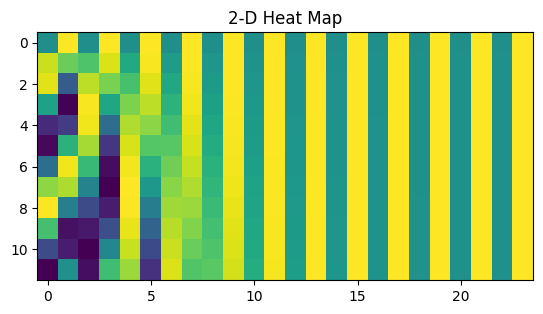

In [130]:
plt.imshow(PEL.emb_arr)
plt.title( "2-D Heat Map" )
plt.show()

## Train

In [111]:
class SelfAttention(torch.nn.Module):

    def __init__(self, n_init, n_seq, n_output):
        super().__init__()

        self.scale = np.sqrt(n_init)
        
        self.Q = torch.nn.Linear(n_init, n_seq)
        self.K = torch.nn.Linear(n_init, n_seq)
        self.V = torch.nn.Linear(n_init, n_init)
        
        self.softmax = torch.nn.Softmax(dim=1)

        self.output = torch.nn.Linear(n_init * n_seq, n_output)

    def forward(self, x):
        
        x_q = self.Q(x)
        x_k = self.K(x)
        x_v = self.V(x)

        x_k_t = torch.transpose(x_k, 1, 2)
        
        output = self.softmax(torch.matmul(x_q, x_k_t) / self.scale)
        output = torch.matmul(output, x_v)
        output = torch.flatten(output, start_dim=1)

        output = self.output(output)

        return output

        

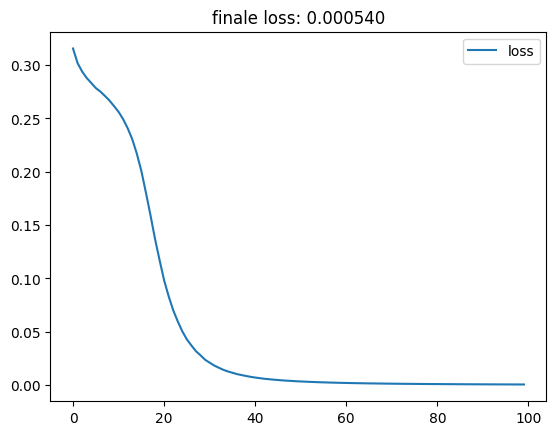

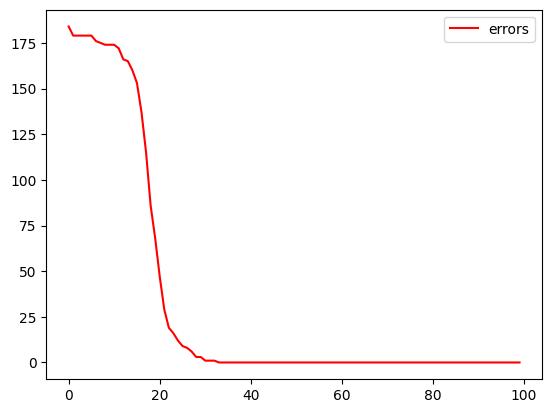

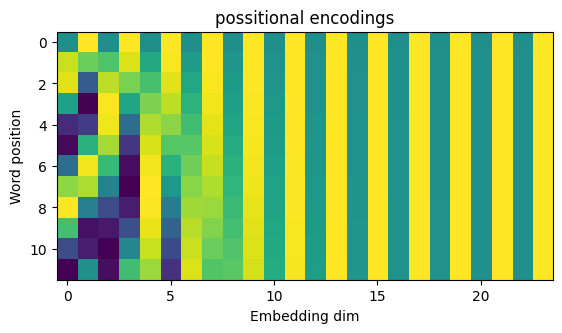

In [124]:
emb_dim = 24
seq_length = 12
batch_size = 16

# Create dataset from string data
dataset = create_dataset(data_str, n_seq=seq_length)

# Create pytorch model
model = torch.nn.Sequential()
model.add_module('fc1', torch.nn.Embedding(n_embedding, emb_dim))
model.add_module('fc2', PositinalEmbeddingLayer(seq_length, emb_dim))
model.add_module('fc3', SelfAttention(emb_dim, seq_length, n_embedding))


# Create data loader
train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

loss_arr = []
err_arr = []

# Train for 100 epochs
for t in range(100):

    # Loss per epoch & no. of errors
    epoch_loss = 0
    errors = 0

    # For every batch
    for batch_idx, (x, y) in enumerate(train_loader):
        
        # Make predictions with the current parameters
        y_pred = model(x)
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        
        # Add loss divided by number of samples per batch
        epoch_loss += torch.sum(loss)
        
        # Add number or wrong predicted words
        errors += torch.sum(torch.argmax(y_pred, dim=1) != torch.argmax(y, dim=1))
        
        # Update the model's parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss and errors per epoch
    # print(epoch_loss / (batch_idx + 1), 'errors:', errors)
    loss_arr.append((epoch_loss / len(dataset)).detach().numpy())
    err_arr.append(errors.numpy())

plt.plot(loss_arr, label='loss')
plt.legend(loc='upper right')
plt.title(f'finale loss: {loss_arr[-1]:.6f}')
plt.show()

plt.plot(err_arr, label='errors', color='red')
plt.legend(loc='upper right')
plt.show()

plt.imshow(model[1].emb_arr)
plt.xlabel('Embedding dim')
plt.ylabel('Word position')
plt.title("possitional encodings")
plt.show()